In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

21/08/11 01:55:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/08/11 01:55:22 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
21/08/11 01:55:22 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
21/08/11 01:55:22 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
21/08/11 01:55:22 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
21/08/11 01:55:22 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045.


In [2]:
# Read in AP Data
df_ap = spark.read.csv('ap_data/18676_filtered_data_sample.csv', header=True, inferSchema=True, sep=",", nullValue="")

In [3]:
from pyspark.sql.functions import isnan, when, count, col, trim
# Fix Column Name Formatting
df_ap = df_ap.toDF(*(c.replace('.', '') for c in df_ap.columns)) 
# Get null value count for each column
# df_ap.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_ap.columns]).toPandas() 

In [4]:
import pyspark.sql.functions as F

# Drop Columns with all null values
def drop_null_columns(df):
    
    _df_length = df.count()
    null_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).collect()[0].asDict()
    to_drop = [k for k, v in null_counts.items() if v >= _df_length]
    df = df.drop(*to_drop)
    
    return df

df_ap = drop_null_columns(df_ap)

21/08/11 01:55:37 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
max_columns = [c for c in df_ap.columns if 'Max' in c]
average_columns = [c for c in df_ap.columns if 'Average' in c]
rate_average_columns = [c for c in df_ap.columns if 'Rate Average' in c]
std_columns = [c for c in df_ap.columns if 'Std Dev' in c]
total_columns = [c for c in df_ap.columns if 'Total' in c]
count_columns = [c for c in df_ap.columns if 'Count' in c]
count_average = [c for c in df_ap.columns if 'Count Average' in c]

In [6]:
columns_to_drop = total_columns + count_columns + rate_average_columns
[columns_to_drop.remove(c) for c in count_average]

df_ap = df_ap.drop(*columns_to_drop)

In [7]:
df_ap = df_ap.filter(F.col('sum') < 50)

In [8]:
# df_ap = df_ap.drop(*out_columns)
df_ap = df_ap.drop('sum')

In [9]:
# Read in Wifi-Data
df_wifi = spark.read.csv('Wifi_CIR/WiFi_CIR_February_2021.csv', header=True, inferSchema=True, sep=",", nanValue='', nullValue='')

# Replace 'No' with None
df_wifi = df_wifi.na.replace('No', None)

In [10]:
# Update serial number column name before merging both data frames
df_ap = df_ap.withColumnRenamed('erm__serial_number', 'SERIAL_NO')

In [11]:
import pyspark.sql.functions as F

# Drop columns from wifi data
columns_to_drop = df_wifi.columns + ['customer', 'id'] 
columns_to_drop.remove('SERIAL_NO')


# Merge dataframes based on 'SERIAL_NO' column and add 'label' column where 1 represents a call-in
df = df_ap.join(df_wifi.withColumn('label', F.lit(1)), 'SERIAL_NO', 'left').fillna(0).drop(*columns_to_drop)
df.groupBy('label').count().toPandas() 
# imbalanced data set ... need alternative evaluation metric to accuracy
# Change Performance Metric: Precision, Recall, F1 Score, ROC AUC
# Resampling Dataset: Under-sampling* (deleting instances of no call-in) or over-sampling (make copies of call-in instance)
# Use stratified sampling instead of random sampling to split data into test and train


,label,count
0,1,258
1,0,48518


In [12]:
max_columns = [c for c in df_ap.columns if 'Max' in c and c not in columns_to_drop]
std_columns = [c for c in df_ap.columns if 'Std' in c and c not in columns_to_drop]

In [13]:
ap_columns = [c for c in df.columns if 'AP' in c]
# df.select(ap_columns).toPandas().hist(bins = 50, figsize = (20, 40))

In [14]:
radio_columns = [c for c in df.columns if 'Radio' in c]
# df.select(radio_columns).toPandas().hist(bins = 50, figsize = (20, 60))

In [15]:
average_columns_with_negative = ['AP upstream_failed_noack_bytes Average', 'AP upstream_failed_noconnect Average', 'AP upstream_failed_percentage Average', 'AP upstream_failed_noconnect_bytes Average',  'AP memory_usage Average', 'AP reboots Average', 'AP uptime Average', 'AP ap_quality_score Average', 'Radio 5 channel Average', 'Radio 24 rx_crc_errors Average', 'Radio 24 rx_phy_errors Average', 'Radio 5 rx_ctl_frames Average', 'Radio 24 rx_packets_be Average', 'Radio 5 tx_data_bytes Average', 'Radio 24 tx_data_bytes Average']

In [16]:
max_columns_with_negative = ['AP ap_quality_score Max', 'AP upstream_failed_noconnect Max', 'AP upstream_failed_noconnect_bytes Max', 'Radio 5 rx_crc_errors Max', 'Radio 24 tx_ctl_frames Max', 'Radio 5 tx_data_bytes Max', 'Radio 24 tx_data_bytes Max', 'Radio 5 tx_data_packets Max']

In [17]:
std_columns_with_negative = ['AP memory_usage Std Dev', 'AP uptime Std Dev', 'AP upstream_failed_noconnect Std Dev', 'AP upstream_failed_noconnect_bytes Std Dev', 'AP upstream_failed_percentage Std Dev', 'Radio 5 channel Std Dev', 'Radio 5 rx_crc_errors Std Dev', 'Radio 24 rx_crc_errors Std Dev', 'Radio 5 tx_data_bytes Std Dev', 'Radio 24 tx_data_bytes Std Dev' ]

In [18]:
cols_with_negative = average_columns_with_negative + max_columns_with_negative + std_columns_with_negative

In [19]:
for c in cols_with_negative:
    df = df.withColumn(c, F.when(F.col(c) < 0, 0).otherwise(F.col(c)))

In [20]:
# Use Logarithmic Transformation to convert Skewed Distributions into Gaussian Distributions
from pyspark.sql.functions import udf
from math import log

@udf("float")
def log_udf(s):
  return log(s + 1, 10)

for c in df.columns[1:-1]:
    df = df.withColumn(c, log_udf(c))

In [21]:
# 1) Split Data into Train and Test
# 2) Perform Undersampling/Oversampling of data 
# 3) Min Max Scaling of Training Data

In [22]:
# Stratified sampling for training/testing data set

# contains 70% of true call-in instances
train_df, test_df = df.randomSplit([0.7, 0.3], seed=123)
# train_df.groupBy('label').count().show() 
# test_df.groupBy('label').count().show() 

In [23]:
from pyspark.sql.functions import col, explode, array, lit

# Calculate ratio needed for oversampling (os)
major_df_os = train_df.filter(col("label") == 0)
minor_df_os = train_df.filter(col("label") == 1)

In [24]:
ratio_os = int(major_df_os.count() / minor_df_os.count())

In [25]:
# Method 1 (primary): Perform Oversampling and Undersampling based on calculated ratio

ratio_os = (ratio_os // 10) # Since we want to undersample the dataset as well, make 'duplication_amount' a smaller value
duplication_amount = range(ratio_os) # will create 'duplication_amount' of copies of the true call in instances 
# duplicate the minority rows
oversampled_df = minor_df_os.withColumn("dummy", explode(array([lit(x) for x in duplication_amount]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows 
combined_df = major_df_os.unionAll(oversampled_df)


# Calculate ratio needed for undersampling (us)
major_df_us = combined_df.filter(col("label") == 0)
minor_df_us = combined_df.filter(col("label") == 1)
ratio_us = int(major_df_us.count() / minor_df_us.count()) 

sampled_majority_df = major_df_us.sample(False, (1/ratio_us))
training_data = sampled_majority_df.unionAll(minor_df_us)
training_data.groupBy('label').count().toPandas() 

,label,count
0,1,3330
1,0,3321


In [26]:
# # Method 2: Perform only undersampling

# major_df_us = train_df.filter(col("label") == 0)
# minor_df_us = train_df.filter(col("label") == 1)

# ratio_us = int(major_df_us.count() / minor_df_us.count()) 

# sampled_majority_df = major_df_us.sample(False, (1/ratio_us))
# training_data = sampled_majority_df.unionAll(minor_df_us)

# training_data.groupBy('label').count().show() 

In [27]:
# # Method 3: Handle imbalanced dataset by assigning higher weight to true call-in class

# training_data = train_df

# dataset_size=float(training_data.select("label").count())
# numPositives=training_data.select("label").where('label == 1').count()
# per_ones=(float(numPositives)/float(dataset_size))*100
# numNegatives=float(dataset_size-numPositives)
# print('The number of ones are {}'.format(numPositives))
# print('Percentage of ones are {}'.format(per_ones)) 

# BalancingRatio= numNegatives/dataset_size
# print('BalancingRatio = {}'.format(BalancingRatio))
# training_data=training_data.withColumn("classWeights", when(training_data.label == 1,BalancingRatio).otherwise(1-BalancingRatio))
# training_data.select("classWeights").show(5)

In [28]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, VectorAssembler, Normalizer, StandardScaler, MaxAbsScaler, ChiSqSelector
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

feature_columns = df.columns[1:-1]

assembler = VectorAssembler(inputCols = feature_columns, outputCol = "features")
minmaxScaler = MinMaxScaler(inputCol = "features", outputCol = "minmax_features")
# scaler = StandardScaler(inputCol='features',outputCol='scaled_features')
# normalizer = Normalizer(inputCol='scaled_features',outputCol='norm_scaled_features')

rf = RandomForestClassifier(featuresCol= "minmax_features", labelCol = "label", maxDepth = 20, numTrees = 20, impurity='entropy', maxBins=10)
# rf = RandomForestClassifier(featuresCol= "minmax_features", labelCol = "label", maxDepth = 20, numTrees = 10, impurity='entropy', maxBins=5)

pipeline = Pipeline(stages=[assembler, minmaxScaler])
pipelineModel = pipeline.fit(training_data)

trainprepDF = pipelineModel.transform(training_data)
testprepDF = pipelineModel.transform(test_df)

rfModel = rf.fit(trainprepDF)
results = rfModel.transform(testprepDF)


21/08/11 02:07:30 WARN DAGScheduler: Broadcasting large task binary with size 1005.6 KiB
21/08/11 02:07:30 WARN DAGScheduler: Broadcasting large task binary with size 1029.1 KiB
21/08/11 02:07:31 WARN DAGScheduler: Broadcasting large task binary with size 1067.0 KiB
21/08/11 02:07:31 WARN DAGScheduler: Broadcasting large task binary with size 1120.4 KiB
21/08/11 02:07:32 WARN DAGScheduler: Broadcasting large task binary with size 1189.0 KiB
21/08/11 02:07:33 WARN DAGScheduler: Broadcasting large task binary with size 1274.8 KiB
21/08/11 02:07:34 WARN DAGScheduler: Broadcasting large task binary with size 1369.2 KiB
21/08/11 02:07:34 WARN DAGScheduler: Broadcasting large task binary with size 1469.2 KiB
21/08/11 02:07:35 WARN DAGScheduler: Broadcasting large task binary with size 1569.7 KiB
21/08/11 02:07:36 WARN DAGScheduler: Broadcasting large task binary with size 1664.3 KiB
21/08/11 02:07:37 WARN DAGScheduler: Broadcasting large task binary with size 1752.1 KiB
21/08/11 02:07:37 WAR

In [29]:
results.select('label', 'features', 'rawPrediction', 'probability', 'prediction').limit(10).toPandas()

21/08/11 02:08:21 WARN DAGScheduler: Broadcasting large task binary with size 1117.6 KiB


,label,features,rawPrediction,probability,prediction
0,0,"[0.44263651967048645, 2.681044816970825, 1.778...","[20.0, 0.0]","[1.0, 0.0]",0.0
1,0,"[0.6971421241760254, 2.6991281509399414, 2.181...","[18.0, 2.0]","[0.9, 0.1]",0.0
2,0,"[0.5006480813026428, 2.6150670051574707, 1.863...","[19.0, 1.0]","[0.95, 0.05]",0.0
3,0,"[0.6971421241760254, 2.359581232070923, 1.9822...","[20.0, 0.0]","[1.0, 0.0]",0.0
4,0,"[0.21085336804389954, 2.635159969329834, 1.0, ...","[20.0, 0.0]","[1.0, 0.0]",0.0
5,0,"[0.8279505372047424, 2.600675582885742, 2.3404...","[20.0, 0.0]","[1.0, 0.0]",0.0
6,0,"[0.4709981679916382, 2.7288641929626465, 1.518...","[19.0, 1.0]","[0.95, 0.05]",0.0
7,0,"[0.6989700198173523, 2.665207624435425, 1.9344...","[14.164383561643834, 5.835616438356165]","[0.7082191780821917, 0.29178082191780824]",0.0
8,0,"[0.3481100797653198, 2.50632905960083, 1.54406...","[17.0, 3.0]","[0.85, 0.15]",0.0
9,0,"[0.48315921425819397, 2.697465658187866, 1.707...","[16.09427799053841, 3.9057220094615905]","[0.8047138995269204, 0.19528610047307954]",0.0


In [30]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
evaluator.setRawPredictionCol('rawPrediction')
# roc_auc = evaluator.evaluate(results)
roc_auc = evaluator.evaluate(results, {evaluator.metricName: 'areaUnderROC'})
pr_auc = evaluator.evaluate(results, {evaluator.metricName: 'areaUnderPR'})
# Measures how capable the model is in distinguishing classes
print("ROC Curve: " + str(roc_auc))
print("PR Curve: " + str(pr_auc))

21/08/11 02:08:32 WARN DAGScheduler: Broadcasting large task binary with size 1095.0 KiB
21/08/11 02:08:52 WARN DAGScheduler: Broadcasting large task binary with size 1095.0 KiB


ROC Curve: 0.7905092897243352
PR Curve: 0.3311360076847125


In [31]:
correct_count = results.filter(results.label == results.prediction).count()
total_count = results.count()

tp = results.filter((results.label == 1) & (results.prediction == 1)).count()
tn = results.filter((results.label == 0) & (results.prediction == 0)).count()
fp = results.filter((results.label == 0) & (results.prediction == 1)).count()
fn = results.filter((results.label == 1) & (results.prediction == 0)).count()

recall = float(tp)/(tp + fn)
precision = float(tp)/(tp + fp)
f1 = (2 * precision * recall) / (precision + recall)

print("All correct results count: ",correct_count)
print("Total count: ",total_count)
print("Accuracy %: ", correct_count/total_count * 100)
print("Recall %: ", recall * 100) # What proportion of actual positives was identified correctly?
print("Precision %: ",precision * 100) # What proportion of positive identifications was actually correct?
print("F1 Score: ", f1)



21/08/11 02:09:14 WARN DAGScheduler: Broadcasting large task binary with size 1125.7 KiB
21/08/11 02:09:57 WARN DAGScheduler: Broadcasting large task binary with size 1125.7 KiB
21/08/11 02:10:20 WARN DAGScheduler: Broadcasting large task binary with size 1125.7 KiB
21/08/11 02:10:44 WARN DAGScheduler: Broadcasting large task binary with size 1125.7 KiB
21/08/11 02:11:08 WARN DAGScheduler: Broadcasting large task binary with size 1125.7 KiB


All correct results count:  14590
Total count:  14645
Accuracy %:  99.624445203141
Recall %:  31.506849315068493
Precision %:  82.14285714285714
F1 Score:  0.45544554455445546


/var/folders/yn/m0pbsyzn6kz3jdnb9f75twwr0000gp/T/ipykernel_71636/1771423035.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png') #svg


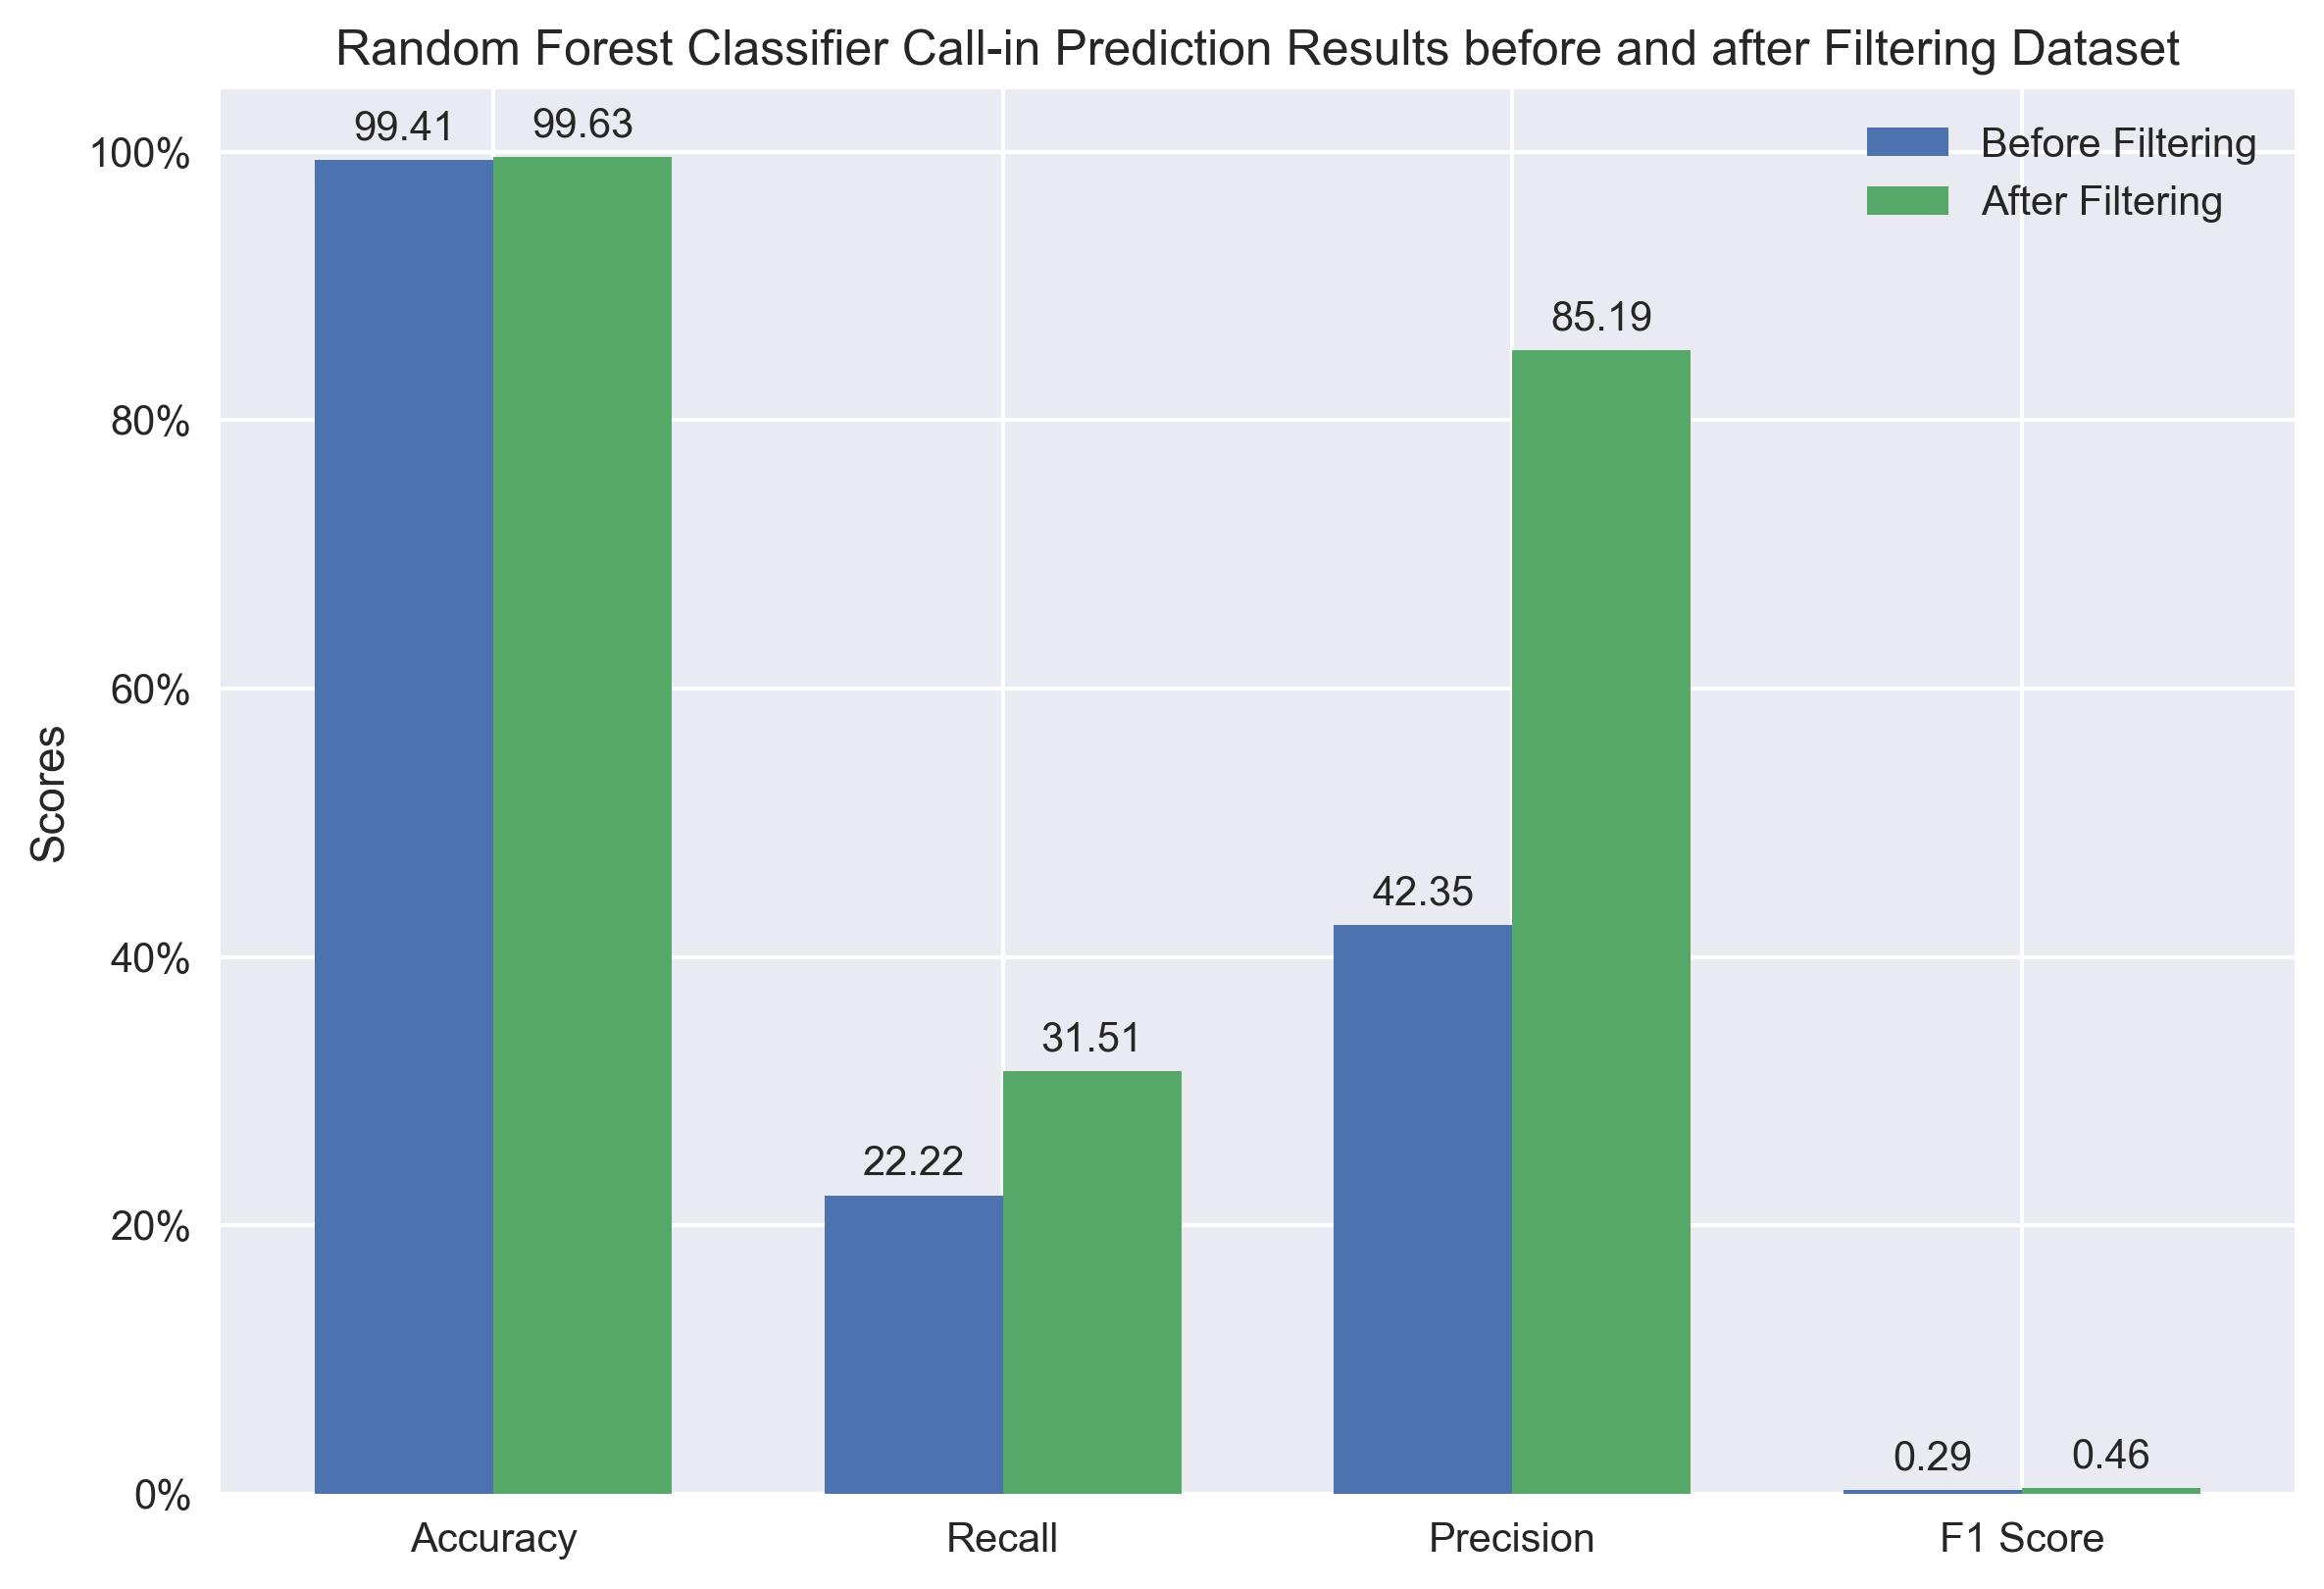

Exception in thread "serve RDD 979 with partitions 0" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:535)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png') #svg
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

unfiltered_results = [99.41, 22.22, 42.35, 29]
filtered_results = [99.63, 31.51, 85.19, 46]
labels = ['Accuracy', 'Recall', 'Precision', 'F1 Score']
plt.style.use('seaborn')
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, unfiltered_results, width, label='Before Filtering')
rects2 = ax.bar(x + width/2, filtered_results, width, label='After Filtering')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Random Forest Classifier Call-in Prediction Results before and after Filtering Dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.show()

In [38]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

In [39]:
import matplotlib.pyplot as plt

# Returns as a list (false positive rate, true positive rate)
preds = results.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')
# Area under curve represents the overall quality of the algorithm/test

21/08/11 11:09:27 WARN DAGScheduler: Broadcasting large task binary with size 1114.6 KiB
21/08/11 11:09:38 WARN DAGScheduler: Broadcasting large task binary with size 1126.1 KiB


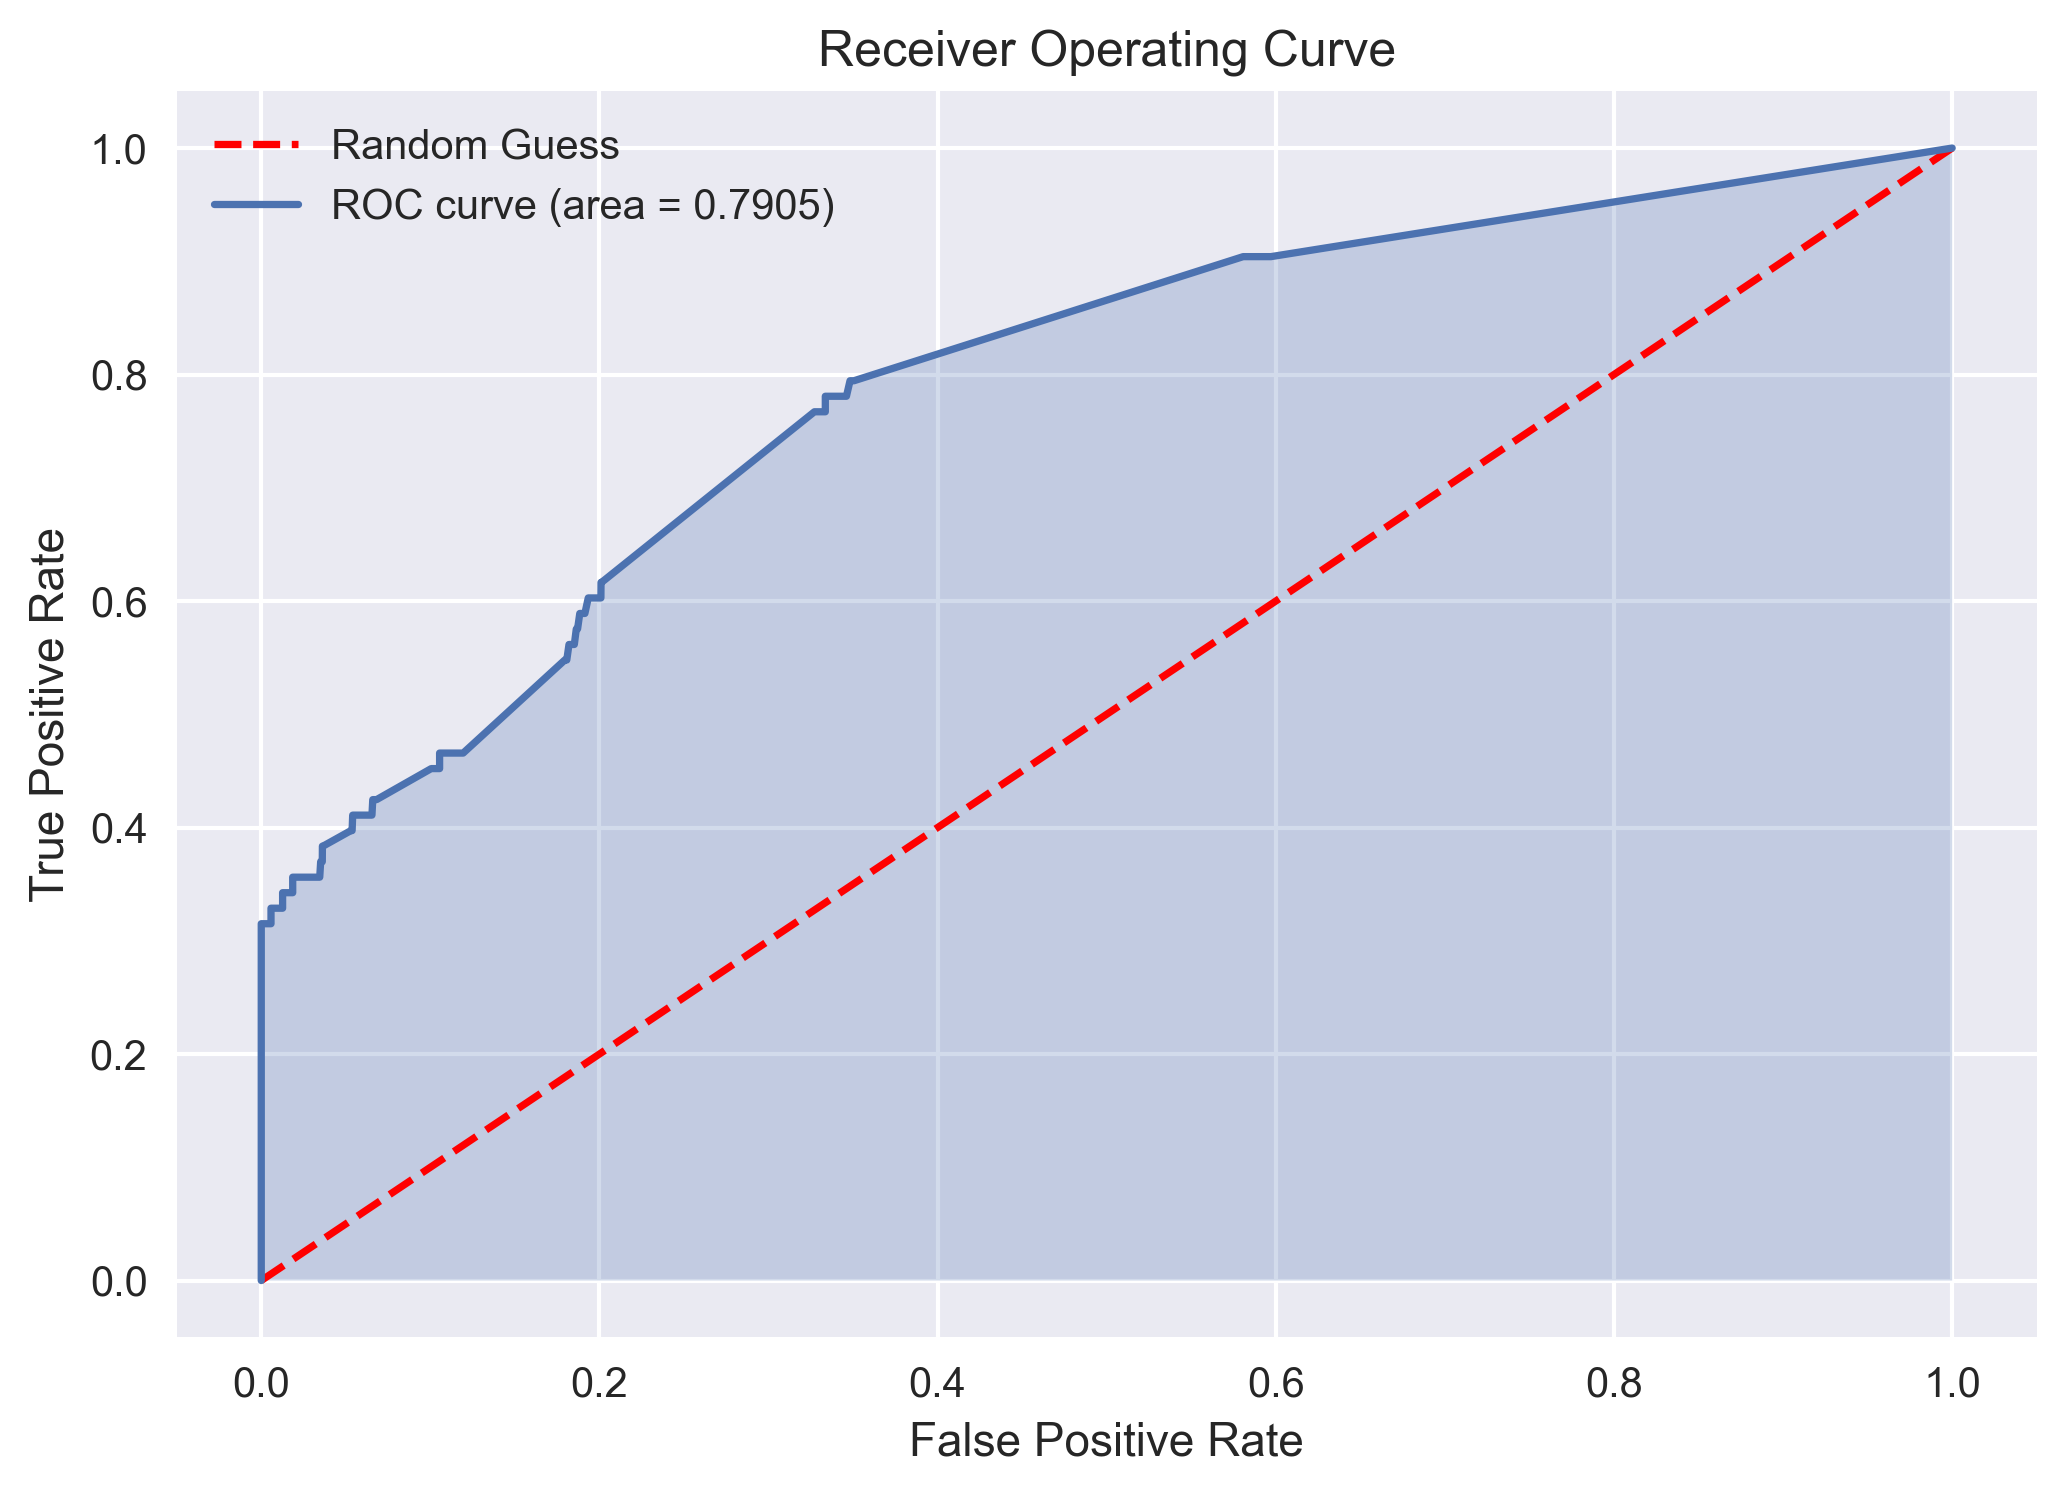

In [44]:
plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.style.use('seaborn')
plt.title('Receiver Operating Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], 'r--', label = 'Random Guess')
plt.plot(x_val, y_val, label = 'ROC curve (area = {})'.format(str(round(roc_auc, 4))))
plt.fill_between(x_val, 0, y_val, alpha = 0.25 )
plt.legend()

In [ ]:
# Cross Validation to optimize parameters for Random Forest
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = ParamGridBuilder()\
    .addGrid(rf.maxBins,[5, 10, 15])\
    .addGrid(rf.numTrees,[10, 20, 25])\
    .addGrid(rf.maxDepth,[10, 20, 25])\
    .build()

In [53]:
# Create 3-fold CrossValidator
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)
# Run cross validations (takes a long time!)
cvModel = cv.fit(trainprepDF)

In [54]:
# Area Under Curve: ROC
predict_train=cvModel.transform(trainprepDF)
predict_test=cvModel.transform(testprepDF)
# Random Forest Model overfits training data to get an ROC AUC of 1.0
print("The area under ROC for train set after CV  is {}".format(evaluator.evaluate(predict_train))) 
print("The area under ROC for test set after CV  is {}".format(evaluator.evaluate(predict_test)))

The area under ROC for train set after CV  is 1.0
The area under ROC for test set after CV  is 0.7511199178372482


In [55]:
# Get optimal parameters
import numpy as np
cvModel.getEstimatorParamMaps()[ np.argmax(cvModel.avgMetrics) ]

{Param(parent='RandomForestClassifier_5eb23e0c3099', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 5,
 Param(parent='RandomForestClassifier_5eb23e0c3099', name='numTrees', doc='Number of trees to train (>= 1).'): 10,
 Param(parent='RandomForestClassifier_5eb23e0c3099', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 20}

In [67]:
# Get Important Features
from matplotlib import pyplot as plt
bestPipeline = cvModel.bestModel
importances = bestPipeline.featureImportances
x_values = list(range(len(importances)))
feature_importances = []
for x in x_values:
    feature_importances.append((feature_columns[x], importances[x]))
feature_importances.sort(key=lambda tup: tup[1], reverse=True)

In [1]:
# Print Feature Importances
for feature, importance in feature_importances:
    print(feature, importance)

NameError: name 'feature_importances' is not defined